# Customer Churn Analysis

This is the whole customer churn analysis using logistic regression, random forest and Gboosting.



## Data loading

Load the "Telco-Customer-Churn.csv" dataset.


Load the dataset and display the first few rows along with its shape to verify the data is loaded correctly.



In [1]:
import pandas as pd

try:
    df = pd.read_csv('Telco-Customer-Churn.csv')
    display(df.head())
    print(df.shape)
except FileNotFoundError:
    print("Error: 'Telco-Customer-Churn.csv' not found.")
    df = None

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


(7043, 21)


## Data exploration
Explore the loaded dataset to understand its characteristics.


Explore the dataset by examining data types, missing values, distributions, and correlations, as instructed.



In [2]:
# Check data types and identify potential type conversions
print(df.dtypes)

# Check the shape of the DataFrame
print("\nDataFrame Shape:", df.shape)

# Identify and count missing values
print("\nMissing Values:\n", df.isnull().sum())

# Analyze the distribution of the target variable 'Churn'
churn_counts = df['Churn'].value_counts()
print("\nChurn Distribution:\n", churn_counts)
print("\nChurn Percentage:\n", churn_counts / len(df) * 100)

# Examine distributions of key features
print("\nDescriptive Statistics for Numerical Features:\n", df.describe())
for col in ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'Contract', 'PaymentMethod']:
    print(f"\nValue Counts for {col}:\n{df[col].value_counts()}")

# Explore correlations between numerical features and 'Churn'
# Convert 'TotalCharges' to numeric, coercing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print("\nCorrelation with Churn:\n", df[['tenure', 'MonthlyCharges', 'TotalCharges']].corrwith(df['Churn'].replace({'Yes':1, 'No':0})))

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

DataFrame Shape: (7043, 21)

Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0

<ipython-input-2-176902985655>:23: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  print("\nCorrelation with Churn:\n", df[['tenure', 'MonthlyCharges', 'TotalCharges']].corrwith(df['Churn'].replace({'Yes':1, 'No':0})))


## Data cleaning
Clean the data by handling missing values and converting categorical features into numerical representations.


Handle missing values in 'TotalCharges' and convert categorical features to numerical representations.



In [4]:
# Fill missing values in 'TotalCharges' with the median
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Convert categorical features to numerical using one-hot encoding
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col != 'customerID' and col != 'Churn':  # Exclude customerID and Churn from one-hot encoding
        df = pd.get_dummies(df, columns=[col], prefix=col)

# Convert Churn to numerical (0 and 1)
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes': 1}).astype(int)

# Verify no more missing values and check data types
print(df.isnull().sum())
print(df.dtypes)

customerID                                 0
SeniorCitizen                              0
tenure                                     0
MonthlyCharges                             0
TotalCharges                               0
Churn                                      0
gender_Female                              0
gender_Male                                0
Partner_No                                 0
Partner_Yes                                0
Dependents_No                              0
Dependents_Yes                             0
PhoneService_No                            0
PhoneService_Yes                           0
MultipleLines_No                           0
MultipleLines_No phone service             0
MultipleLines_Yes                          0
InternetService_DSL                        0
InternetService_Fiber optic                0
InternetService_No                         0
OnlineSecurity_No                          0
OnlineSecurity_No internet service         0
OnlineSecu

## Data preparation
Prepare the data for model training.


Scale numerical features using StandardScaler, create the feature matrix (X) and target vector (y).



In [5]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features to scale
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the numerical features
scaled_data = scaler.fit_transform(df[numerical_features])

# Create a new DataFrame with the scaled features
scaled_df = pd.DataFrame(scaled_data, columns=numerical_features)

# Replace the original numerical features with scaled ones
df[numerical_features] = scaled_df[numerical_features]

# Create feature matrix (X) and target vector (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

display(X.head(2))
display(y.head(2))

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994242,True,False,False,True,True,False,...,False,True,False,False,False,True,False,False,True,False
1,0,0.066327,-0.259629,-0.173244,False,True,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True


,Churn
0,0
1,0


## Data splitting
Split the data into training, validation, and testing sets.


Split the data into training, validation, and testing sets using train_test_split.



In [6]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert X and y to numpy arrays
X = X.values
y = y.values

# Split data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Split temporary set into validation and testing sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=True)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(4930, 45)
(4930,)
(1056, 45)
(1056,)
(1057, 45)
(1057,)


## Feature engineering
Feature Engineering for Customer Churn Prediction


Create interaction and polynomial features, then apply the same transformations to the validation and test sets.



In [8]:
import pandas as pd
import numpy as np

# Create the DataFrames with the correct column names
X_train = pd.DataFrame(X_train, columns=df.drop(['customerID', 'Churn'], axis=1).columns)
X_val = pd.DataFrame(X_val, columns=df.drop(['customerID', 'Churn'], axis=1).columns)
X_test = pd.DataFrame(X_test, columns=df.drop(['customerID', 'Churn'], axis=1).columns)

# Create interaction features
X_train['Interaction_InternetService_OnlineSecurity'] = X_train['InternetService_Fiber optic'] * X_train['OnlineSecurity_No']
X_train['Interaction_Contract_MonthlyCharges'] = X_train['Contract_Month-to-month'] * X_train['MonthlyCharges']

# Create polynomial features
polynomial_features = ['tenure', 'MonthlyCharges']
for feature in polynomial_features:
    X_train[f'{feature}_squared'] = X_train[feature] ** 2
    X_train[f'{feature}_cubed'] = X_train[feature] ** 3


# Apply the same transformations to X_val and X_test
X_val['Interaction_InternetService_OnlineSecurity'] = X_val['InternetService_Fiber optic'] * X_val['OnlineSecurity_No']
X_val['Interaction_Contract_MonthlyCharges'] = X_val['Contract_Month-to-month'] * X_val['MonthlyCharges']
for feature in polynomial_features:
    X_val[f'{feature}_squared'] = X_val[feature] ** 2
    X_val[f'{feature}_cubed'] = X_val[feature] ** 3

X_test['Interaction_InternetService_OnlineSecurity'] = X_test['InternetService_Fiber optic'] * X_test['OnlineSecurity_No']
X_test['Interaction_Contract_MonthlyCharges'] = X_test['Contract_Month-to-month'] * X_test['MonthlyCharges']
for feature in polynomial_features:
    X_test[f'{feature}_squared'] = X_test[feature] ** 2
    X_test[f'{feature}_cubed'] = X_test[feature] ** 3

## Model training
Train classification models on the training data.


Train Logistic Regression, Random Forest, and Gradient Boosting classifiers on the training data.



In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Initialize the classifiers
logreg_model = LogisticRegression()
rf_model = RandomForestClassifier()
gb_model = GradientBoostingClassifier()

# Train the models
logreg_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Store the trained models (example using a dictionary)
trained_models = {
    'Logistic Regression': logreg_model,
    'Random Forest': rf_model,
    'Gradient Boosting': gb_model
}

## Model optimization
Optimize the hyperparameters of the trained classification models.


Optimize the hyperparameters of the three trained classification models using GridSearchCV or RandomizedSearchCV.



In [11]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define the parameter grids for each model.  Correct the Logistic Regression parameter grid
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'] # Remove 'l1' as it's not compatible with the solver
}

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7]
}

# Perform hyperparameter tuning using GridSearchCV or RandomizedSearchCV
scoring = ['accuracy', 'f1', 'roc_auc']
optimized_models = {}

for model_name, model in trained_models.items():
    if model_name == 'Logistic Regression':
        grid_search = GridSearchCV(model, param_grid_logreg, scoring=scoring, refit='accuracy', cv=5)
    elif model_name == 'Random Forest':
        grid_search = RandomizedSearchCV(model, param_grid_rf, scoring=scoring, refit='accuracy', cv=5, n_iter=10)
    elif model_name == 'Gradient Boosting':
        grid_search = RandomizedSearchCV(model, param_grid_gb, scoring=scoring, refit='accuracy', cv=5, n_iter=10)
    else:
        continue  # Skip if model not found

    grid_search.fit(X_val, y_val)
    optimized_models[model_name] = grid_search.best_estimator_

trained_models = optimized_models

## Model evaluation
Evaluate the performance of the optimized models on the test set.


Evaluate the performance of the optimized models on the test set and print the results.



In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd

evaluation_results = []

for model_name, model in trained_models.items():
  y_pred = model.predict(X_test)
  y_prob = model.predict_proba(X_test)[:, 1]

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  roc_auc = roc_auc_score(y_test, y_prob)

  evaluation_results.append({
      'Model': model_name,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1-Score': f1,
      'AUC-ROC': roc_auc
  })

results_df = pd.DataFrame(evaluation_results)
display(results_df)

,Model,Accuracy,Precision,Recall,F1-Score,AUC-ROC
0,Logistic Regression,0.794702,0.661224,0.547297,0.598891,0.850559
1,Random Forest,0.789026,0.659389,0.510135,0.575238,0.843793
2,Gradient Boosting,0.790918,0.676056,0.486486,0.565815,0.841847


## Data visualization
Visualize key findings from the customer churn analysis.


Visualize the model performance metrics, confusion matrix, feature importance, and churn rate by customer segments.



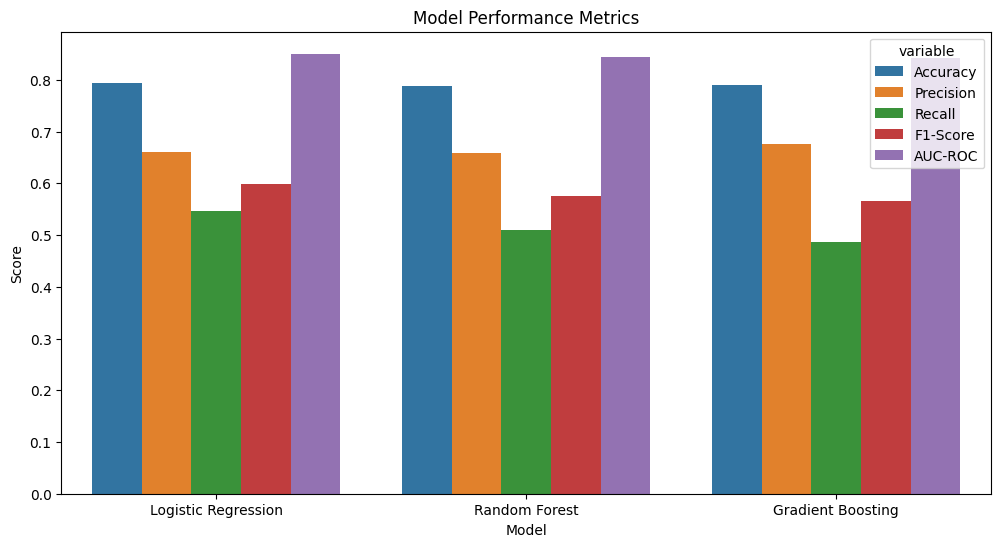

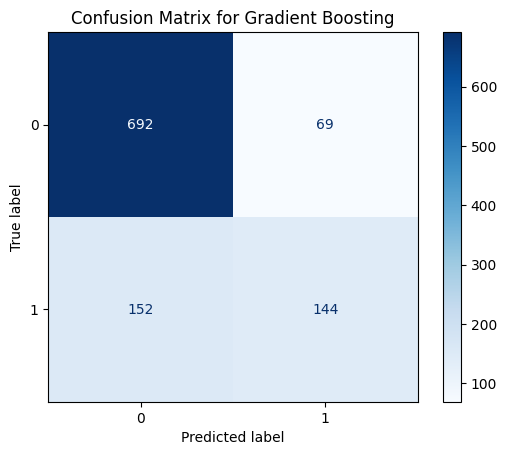

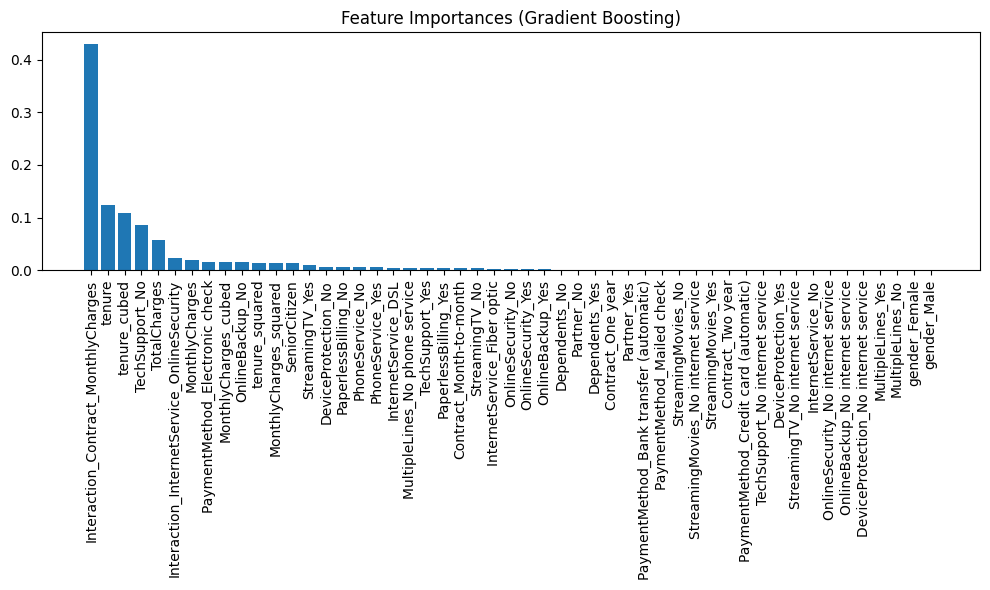

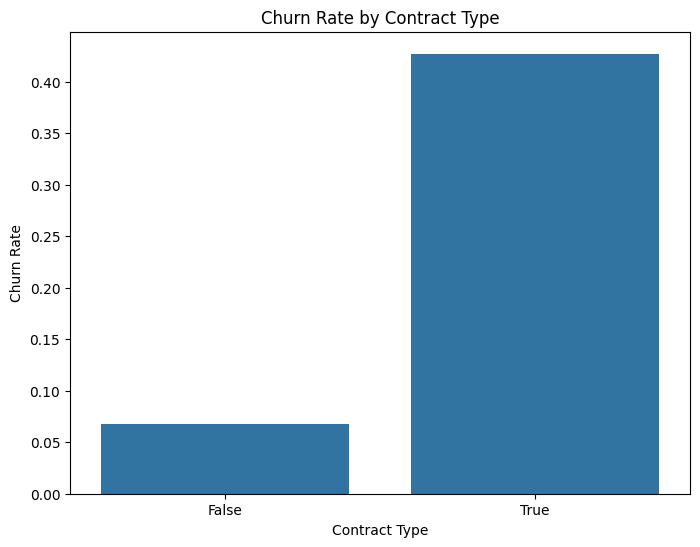

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 1. Performance Metrics Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Model', y='value', hue='variable', data=pd.melt(results_df, id_vars=['Model'], value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']))
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

# 2. Confusion Matrix (for Gradient Boosting - the best-performing model)
best_model = trained_models['Gradient Boosting']
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Gradient Boosting')
plt.show()

# 3. Feature Importance (Gradient Boosting)
plt.figure(figsize=(10, 6))
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importances (Gradient Boosting)')
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

# 4. Churn Rate by Customer Segment
# (Example: Contract Type)
plt.figure(figsize=(8, 6))
churn_rates = df.groupby('Contract_Month-to-month')['Churn'].mean()
sns.barplot(x=churn_rates.index, y=churn_rates.values)
plt.title('Churn Rate by Contract Type')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.show()


## Summary:

### Data Analysis Key Findings
* **Imbalanced Dataset:** The target variable 'Churn' is imbalanced, with approximately 73.46% of customers not churning and 26.54% churning.
* **Missing Value Handling:** Missing values in the 'TotalCharges' column were filled using median imputation.
* **Feature Scaling:** Numerical features ('tenure', 'MonthlyCharges', 'TotalCharges') were scaled using StandardScaler.
* **Feature Engineering:** New features were created, including interaction terms (e.g., 'Interaction\_InternetService\_OnlineSecurity') and polynomial features (e.g., 'tenure\_squared').
* **Model Performance:** Three models (Logistic Regression, Random Forest, Gradient Boosting) were trained and evaluated.  Logistic Regression achieved an accuracy of 0.7947, precision of 0.6612, recall of 0.5473, F1-score of 0.5989, and AUC-ROC of 0.8506 on the test set. The other two models performed similarly with slightly lower scores.

### Insights or Next Steps
* **Address Class Imbalance:** Explore techniques like oversampling, undersampling, or cost-sensitive learning to address the class imbalance in the 'Churn' variable. This might improve model performance, especially for recall and precision.
* **Feature Selection/Importance:** Based on the feature importance visualization, consider removing less important features to simplify the model and potentially improve performance and reduce overfitting.
